In [1]:
%load_ext autoreload

Controller configuration
-----------------------

Overall configuration is held in a class, Config. A Config object holds the list of linux containers, Corsa switches, simulated sites. The following is used to generate and save the configuration. It explains what the various data types are and being used. Refer to coord.py for more details on each of the objects.

In [26]:
%autoreload 2

from coord import Switch, Container, Site, Config, get_config

# Corsa Switches - rtt to SCinet Denver.
wash_sw = Switch("wash-tb-of-1","192.168.120.41",None,vfc="br2",ofport=11,rtt=38.8)
cern_sw = Switch("cern-272-tb-of-1","192.168.120.36",None,"br2",10,rtt=89.5)
amst_sw = Switch("amst-tb-of-1","192.168.120.35",None,"br1",23,rtt=82.5)
aofa_sw = Switch("aofa-tb-of-1","192.168.120.33",None,"br2",2,rtt=5.3)
denv_sw = Switch("denv-tb-of-1","192.168.120.37",None,"br1",10,rtt=2)
atla_sw = Switch("atla-tb-of-1","192.168.120.34",None,"br1",9,rtt=39.5)
switches=[wash_sw,cern_sw,amst_sw,aofa_sw,denv_sw]

# Linux Containers
wash_dtn = Container("wash-192","192.168.120.192",port="eth1")
cern_dtn = Container("cern-194","192.168.120.194",port="eth1")
amst_dtn = Container("amst-190","192.168.120.190",port="eth1")
aofa_dtn = Container("aofa-191","192.168.120.191",port="eth1")
denv_dtn = Container("denv-201","192.168.120.201",port="eth1")
atla_dtn = Container("atla-200","192.168.120.200",port="eth1")
containers = [wash_dtn,cern_dtn,amst_dtn,aofa_dtn,denv_dtn,atla_dtn]

# Simulated sites
wash = Site(name="wash", switch=wash_sw, container=wash_dtn)
amst = Site(name="amst", switch=amst_sw, container=amst_dtn)
cern = Site(name="cern", switch=cern_sw, container=cern_dtn)
denv = Site(name="denv", switch=denv_sw, container=denv_dtn)
aofa = Site(name="aofa", switch=aofa_sw, container=aofa_dtn)
atla = Site(name="atla", switch=atla_sw, container=atla_dtn)
#scinet = Site(name="scinet", switch=None, container=scinet_dtn)

sites = [wash,amst,cern,denv,aofa,atla]

config =Config(switches=switches,containers=containers,sites=sites)
config.save(config_file="demo.config")

Switches,containers, etc are python objects. There is no access functions to their values. They can directly be accessed:

In [32]:
print wash_sw.ip, wash_sw.vfc, wash_sw.ofport, wash_sw.rtt

192.168.120.41 br2 11 38.8


In [27]:
print config.switches
print config.containers
print config.sites

[wash-tb-of-1, cern-272-tb-of-1, amst-tb-of-1]
[wash-192, cern-194, amst-190, aofa-191]
[wash, amst, cern, denv, aofa]


Once the config is written into a file, it can be retrieved later:

In [28]:
new_config = get_config(config_file="demo.config")

In [29]:
new_config.switches

[wash-tb-of-1, cern-272-tb-of-1, amst-tb-of-1]

In [118]:
from trafficgen import traffic_gen
from coord import SingleFileGen

def get_sources(config):
    sources=[]
    dtns = config.containers
    for dtn in dtns:
        sources.append(dtn.name)
    return sources

sources = get_sources(config)
capacity = 500000 # 500 Mbps
epoch = 5 * 60 # 5 mins
#gen = traffic_gen(sources,capacity,epoch)
buckets=[30*1024,15*1024,10*1024,5*1024,1*1025,512,128]
gen = SingleFileGen(sources,capacity,epoch,buckets)

In [119]:
reqs = gen.generate_requests()

10240 0.196608
5120 0.098304
30720 0.589824
5120 0.098304


In [117]:
print reqs

[src= wash-192 dst: 0 size: 10240 deadline: 0.211029282841, src= cern-194 dst: 0 size: 5120 deadline: 0.132097514048, src= amst-190 dst: 0 size: 30720 deadline: 1.08667391744, src= aofa-191 dst: 0 size: 5120 deadline: 0.321079199776]


In [99]:
x=[]
y=[]
for i in range (0,1000):
    x.append(i)
    y.append(np.random.exponential(scale=0.1))

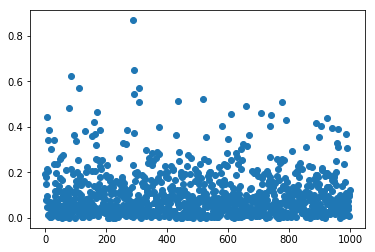

In [100]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(x,y, 'o')

plt.show()

In [102]:
count = 0
for z in y:
    #print z
    if z <= 0.01:
        count +=1
print count


83


In [127]:
import numpy as np

import scheduler

class SingleFileGen:

    def __init__(self,sources,C,epoch,buckets,padding=1.2):
        self.capacity = C
        self.epoch = epoch
        self.nodes = sources
        self.buckets=buckets
        self.padding = padding
        np.random.seed(3)


    def generate_requests(self):

    	requests = []
    	for src in self.nodes:
            size = np.random.choice(self.buckets)
            min_duration = (size * 8 * 1000 * self.padding) / self.capacity 
            print size,self.capacity, min_duration
            duration = min_duration * (np.random.exponential(scale=1)) + min_duration
            dst = 0
            req = scheduler.Request(src,dst,size,0,duration)
            requests.append(req)
        return requests

def get_sources(config):
    sources=[]
    dtns = config.containers
    for dtn in dtns:
        sources.append(dtn.name)
    return sources

sources = get_sources(config)
capacity = 500000 # 500 Mbps
epoch = 5 * 60 # 5 mins
#gen = traffic_gen(sources,capacity,epoch)
buckets=[30*1024,15*1024,10*1024,5*1024,1*1025,512,128]
gen = SingleFileGen(sources,capacity,epoch,buckets)
reqs = gen.generate_requests()

10240 500000 196.608
5120 500000 98.304
30720 500000 589.824
5120 500000 98.304


In [129]:
reqs

[src= wash-192 dst: 0 size: 10240 deadline: 211.029282841,
 src= cern-194 dst: 0 size: 5120 deadline: 132.097514048,
 src= amst-190 dst: 0 size: 30720 deadline: 1086.67391744,
 src= aofa-191 dst: 0 size: 5120 deadline: 321.079199776]